# Extreme center-outward quantile region estimation

This notebook is a copy of the notebook extreme_quantile_region_estimation_1.ipynb with another choice of target distribution whose support isn't contained in any orthant and have extreme values in three disjoint sets.

In this notebook, we implement a novel method to estimate center-outward quantile regions-introduced in Hallin et al.(2021)-of order close to one and provide an illustration of it for data generated using the package MLExtreme and contained in the 2D positive orthant. The extremal index $\alpha$ of the target random variable $Y$ is deemed to be known whereas in practice on real data it would be estimated using well known methods like the Hill estimator and plugged in our estimator.

We consider a target distribution $\mathbb{P}_Y$ and a reference distribution $\mathbb{P}_X$ both regularly varying with the same index $\alpha$, same auxiliary function $b$ and limit measures $\mu$ and $\nu$ respectively. Under appropriate assumptions -satisfied in our example- we have two closed convex functions $\psi$ and $\bar\psi$ such that $\mathbb{P}_Y = \nabla\psi_\# \mathbb{P}_X$ and $\mu = \left(\nabla\bar\psi_\# \nu\right)_{|\mathbb{R}^{2}\setminus\{0\}}$.

Relying on the cyclically monotone interpolation $\nabla\hat\psi$ proposed in Hallin et al.(2021), we estimate $\nabla\bar\psi$ by $\nabla\hat{\bar\psi}=b(t)^{-1}\nabla\hat\psi(b(t)\cdot)$ for some large $t$ as described in the New Materiel section of the working document.

## General imports and parameters

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import linear_sum_assignment

from shapely import Polygon
from shapely.geometry import Point

from utils import *

First we initialize the parameters of our simulation.

In [2]:
np.random.seed(2025)

# Size of our sample
n = 10000 #10000
# Extremal index
alpha = 2.5
# Order of the quantile region we want to estimate
q = 0.999
# Share of the data deemed extreme
p_t = 0.025
# A quantity used later in the computations
beta = (q-1+p_t) / p_t

## Data generation

We generate iid random variables $Y_1,...,Y_n$ using the package MLExtreme from a distribution with extreme value index $\alpha$ and which are support included in the positive orthant.

Let $U_1,...,U_n$ be iid random variables uniform on the intersection of unit sphere with the positive orthant. The reference distribution is built as $X_i = |Y_i|*U_i$

Defining the reference distribution this way assure that both the reference distritution and the target distribution have the same extremal index and let us believe that phenomena like hidden regular variation that may happen in the target distribution are present too in the reference distribution.

[See https://github.com/hi-paris/MLExtreme/blob/main/tutorials/dirichlet_mixture_model.ipynb]

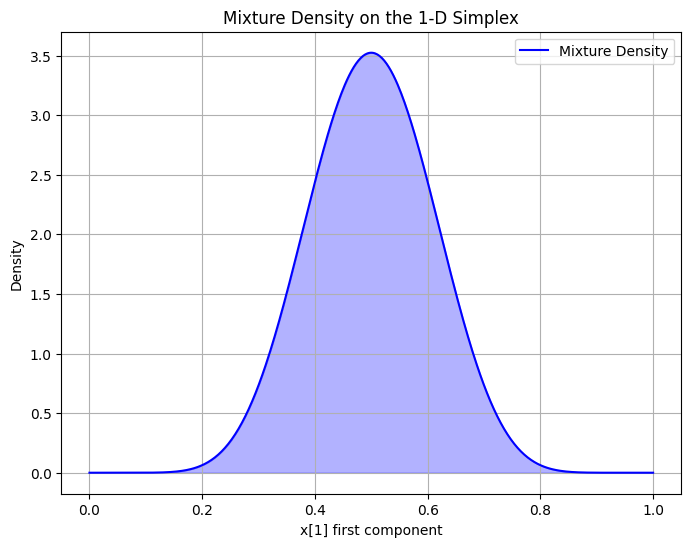

In [3]:
import MLExtreme as mlx

#splits = [0.1, 0.325, 0.55, 0.775, 1]
splits_generator = [0.05, 0.35, 0.65, 0.95, 1]
generators = []

generators.append(
    lambda n: np.random.multivariate_normal(np.zeros(2), np.eye(2) / 10, n).T
)

# Example RV-dirimix  data generation p = 2
dimsimp = 2  # Dimensionality of the simplex (2D in this case)
k = 3  # Number of components in the Dirichlet mixture

# Mixture means (Mu), log scale (lnu), and weights (wei)
#Mu = np.array([[0.9,0.1], [0.1,0.9], [0.5,0.5]])  # k* p matrix of means
Mu = np.array([[0.5,0.5], [0.5,0.5], [0.5,0.5]])  # k* p matrix of means
lnu = np.log(20) * np.ones(k)  # log(10) for both components
wei = np.array([1,1,2])  # weights for the mixture components
Mu, wei = mlx.normalize_param_dirimix(Mu, wei)
# inspect the angular density
Mu_wei = wei  @ Mu
# Display the result
#print(Mu_wei)
mlx.plot_pdf_dirimix_2D(Mu, wei, lnu)

# Generate the dataset using the gen_rv_dirimix function.
# As an adversarial (bulk) angular parameter, use the  center of the simplex

generators.append(
    lambda n : mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, index_weight_noise=3,
                       Mu_bulk=(np.ones(dimsimp)/dimsimp).reshape(1, dimsimp),
                       wei_bulk=np.ones(1),
                       lnu_bulk=np.ones(1) * np.log(2),
                       size=n).T
)

generators.append(
    lambda n : - mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, index_weight_noise=3,
                       Mu_bulk=(np.ones(dimsimp)/dimsimp).reshape(1, dimsimp),
                       wei_bulk=np.ones(1),
                       lnu_bulk=np.ones(1) * np.log(2),
                       size=n).T
)

generators.append(
    lambda n : ( mlx.gen_rv_dirimix(alpha, Mu, wei, lnu, index_weight_noise=3,
                       Mu_bulk=(np.ones(dimsimp)/dimsimp).reshape(1, dimsimp),
                       wei_bulk=np.ones(1),
                       lnu_bulk=np.ones(1) * np.log(2),
                       size=n) * np.array([-1,1]) ).T
)

#generators.append(
#    lambda n: np.random.multivariate_normal(np.zeros(2), np.eye(2) / 10, n).T
#)

def unif_simplex_p_orthant(n):
    tmp = np.random.uniform(0,1,n).T
    d = np.random.uniform(0,1,n)
    X = d * np.array( (tmp, 1-tmp) )
    return X

def unif_simplex(n):
    unif = np.random.uniform(0,1,n)
    X = np.zeros((2,n))
    last = 0
    last_n = 0
    
    orthant_params = [
                    np.array([1,1]),
                    np.array([1,-1]),
                    np.array([-1,1]),
                    np.array([-1,-1])
                    ]

    for split, orthant_param in zip(list(np.linspace(0,1,5))[1:], orthant_params):
        n_tmp = ((unif <= split) & (unif > last)).sum()
        
        X[:,last_n:(last_n+n_tmp)] = (unif_simplex_p_orthant(n_tmp).T * orthant_param).T

        last_n += n_tmp
        last = split
    
    return X

generators.append(
    unif_simplex
)

def generator(n):
    unif = np.random.uniform(0,1,n)
    X = np.zeros((2,n))
    last = 0
    last_n = 0
    
    for split, gen in zip(splits_generator, generators):
        n_tmp = ((unif <= split) & (unif > last)).sum()
        
        X[:,last_n:(last_n+n_tmp)] = gen(n_tmp)

        last_n += n_tmp
        last = split

    return X

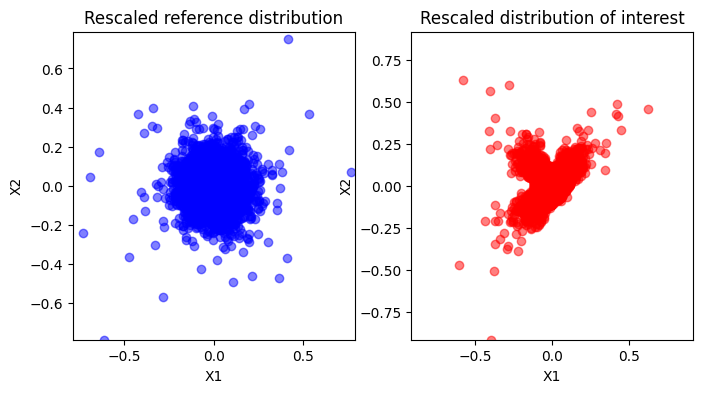

In [4]:
# Generate the datasets
Y = generator(n)
X = generate_reference_data(Y)

# store original data
X_real, Y_real = X.copy(), Y.copy()

# normalize data
norm_max = np.sqrt( (Y **2).sum(axis=0) ).max()
X, Y = X/norm_max, Y/norm_max

#rescale = lambda t : np.abs(t)**(alpha/4) * t / (np.abs(t) + 0.00000001)
def rescale(t):
    norms = np.sqrt( ((t)**2).sum(axis=0) )
    dir = t / ( norms + 0.000000001)
    return (norms**(alpha/4)) * dir
    
X_rescaled = rescale(X) #X**(alpha/4)
Y_rescaled = rescale(Y) #Y**(alpha/4)
fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 
axs[0].scatter(X_rescaled[0, :], X_rescaled[1, :], color='blue', alpha=0.5)
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
max_range = max(np.max(np.abs(X_rescaled[0, :])), np.max(np.abs(X_rescaled[1, :])))
axs[0].set_xlim(-max_range, max_range)
axs[0].set_ylim(-max_range, max_range)
axs[0].set_title('Rescaled reference distribution')
axs[1].scatter(Y_rescaled[0, :], Y_rescaled[1, :], color='red', alpha=0.5)
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
max_range = max(np.max(np.abs(Y_rescaled[0, :])), np.max(np.abs(Y_rescaled[1, :])))
axs[1].set_xlim(-max_range, max_range)
axs[1].set_ylim(-max_range, max_range)
axs[1].set_title('Rescaled distribution of interest')
plt.show()


## Estimator function building

We solve the discrete Monge Problem and build the smooth cyclically monotone interpolated transport map proposed in Hallin et al.(2021) and relying on Yosida regularization. The code can be found in $\emph{utils.py}$.

In [5]:
# Solve discrete Monge Problem
C = distmat(X,Y)
LSA = linear_sum_assignment(C)
optimal_assignment = LSA[1]

# Reorder Y so that X[:,i] is sent to Y[:,i]
# by the optimal transport map
Y = Y[:,optimal_assignment]
Y_real = Y_real[:,optimal_assignment]

# Compute the parameters of the estimator
epsilon_star, psi = compute_params(X,Y)

# Build the smooth interpolation of the transport map
T = lambda x : smooth_T(x, Y, epsilon_star, psi, norm_max, lr=epsilon_star/5, steps=3000)

We check the computed solutions.

In [6]:
costs = compute_costs(X, Y)

spread, tmp = check_optimality_cdtn(costs, psi, epsilon_star, epsilon_star)
print( f"Check condition 1: {n*n - tmp.sum()} (should be zero)")
np.sort( spread.flatten() )[:20]

spread_bis, tmp_bis = check_optimality_cdtn_bis(X, Y, psi)
print( f"Check condition 2: {n - tmp_bis.sum()} (should be zero)")

Check condition 1: 0.0 (should be zero)
Check condition 2: 0.0 (should be zero)


Finally, we give some illustration of the fact that the smoothed estimated transport plan is constant in some neighbourhood of each point in the reference sample.

In [7]:
N = 50

reference = np.zeros((2, 4*N))
for i in range(N):
    reference[:,4*i] = Y_real[:,i]
    reference[:,4*i + 1] = Y_real[:,i]
    reference[:,4*i + 2] = Y_real[:,i]
    reference[:,4*i + 3] = Y_real[:,i]

def compute_spread(delta):
    Computed = np.zeros((2,4*N))
    for i in range(N):
        Computed[:,4*i] = T(X_real[:,i]+delta*np.array([1,1]))
        Computed[:,4*i + 1] = T(X_real[:,i]+delta*np.array([1,-1]))
        Computed[:,4*i + 2] = T(X_real[:,i]+delta*np.array([-1,1]))
        Computed[:,4*i + 3] = T(X_real[:,i]+delta*np.array([-1,-1]))
    return (np.abs( reference - Computed)**2).sum() / (4*N)

vectorized_spread = np.vectorize( compute_spread )

t = (2)**(-np.arange(0, 10, 0.5))

deltas = vectorized_spread( t )

/Users/alexandremansire/Documents/EVT_stage/stagem2/numerics/utils.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_0 = torch.tensor( x.clone().detach(), dtype=torch.float64, requires_grad=True)
/Users/alexandremansire/Documents/EVT_stage/stagem2/numerics/utils.py:379: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_0 = torch.tensor( x.clone().detach(), dtype=torch.float64, requires_grad=True)


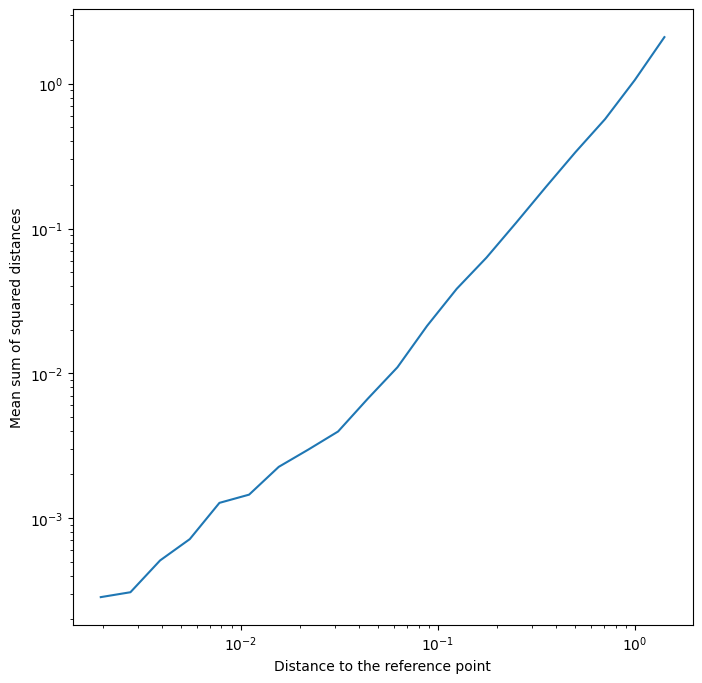

In [8]:
plt.figure(figsize=(8,8))
plt.plot( np.sqrt(2)*t, deltas)
plt.ylabel('Mean sum of squared distances')
plt.xlabel('Distance to the reference point')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Rays transportation 
We illustrate below what happens to the rays from the reference space when transported toward the target space by the interpolated optimal transport plan.

One can notice that transported rays all end up going in areas of the space where there is extreme values. This is a usefull property that can be used in some proofs of the approximation results.

In [9]:
norm = np.sqrt(np.sum((X_real.T)**2, axis=1))
tmpb = norm.copy()
tmpb.sort()
b = tmpb[int(n*(1-p_t))]

In [10]:
n_dir = 20
n_points = 50
R_max = tmpb[int(n*(1-0.005))]
Theta = np.linspace(0, 2*np.pi,n_dir)

X_rays = np.zeros((n_dir, 2, n_points))
Y_rays = np.zeros((n_dir, 2, n_points))
for i, theta in enumerate(Theta):
    tmp = np.repeat( np.vstack((np.cos(theta), np.sin(theta).T)).T, n_points, axis=0)
    rad = np.linspace(0.05, R_max, n_points) 
    X_rays[i,:,:] = rad * tmp.T
    for j in range(n_points):
        Y_rays[i,:,j] = T(X_rays[i,:,j])

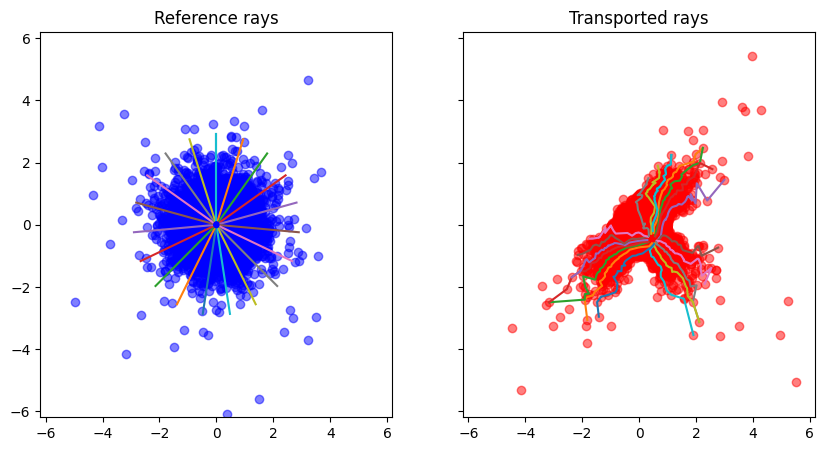

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True) 

tmp = rescale( X_real )
axs[0].scatter( tmp[1,:], tmp[0,:], c='blue', alpha=0.5)
for i in range(n_dir):
    tmp = rescale( X_rays[i,:,:] )
    axs[0].plot(tmp[1,:], tmp[0,:])
axs[0].set_title('Reference rays')

tmp = rescale( Y_real )
axs[1].scatter( tmp[1,:], tmp[0,:], c='red', alpha=0.5)
for i in range(n_dir):
    tmp = rescale( Y_rays[i,:,:] )
    axs[1].plot(tmp[1,:], tmp[0,:])
max_range = max(np.max(Y_rescaled[0, :]), np.max(Y_rescaled[1, :]))
axis_max = max( rescale(Y_rays.max()), rescale(Y_real.max()) )
axs[1].set_xlim(-axis_max, axis_max)
axs[1].set_ylim(-axis_max, axis_max)
axs[1].set_title('Transported rays')
plt.show()


## Center-outward tail quantile region estimation

Computational costs prompt us to use few points and then simply rely on some linear interpolation to approximate the center-outward tail quantile contour.

Since the contours are not connexe in general, we suggest to use some kind of elbow method to choose the threshold above which we do not connect two points by a line.

We approximate the contour of order 0 by 
$$
\mathcal{C}^{\tau}(0) = \partial\bar\psi(\mathbb{S}^{d-1}) \approx \nabla\hat{\bar{\psi}}(\mathbb{S}^{d-1})
$$

And then recover the region thanks to the relation
$$
\mathbb{C}^{\tau}(q) 
= (1-q)^{-1/\alpha} \bigcup_{y\in\mathcal{C}^{\tau}(0)}[0,y]
\approx (1-q)^{-1/\alpha} \{[0,\nabla\hat{\bar{\psi}}(x)] \::\: |x| = 1\}
$$

In [12]:
i = 4 * 1000 # Number of points used to draw the contour

norm = np.sqrt(np.sum((X_real.T)**2, axis=1))
tmpb = norm.copy()
tmpb.sort()
b = tmpb[int(n*(1-p_t))]

Theta = np.linspace(0,2*np.pi,i)
tmp = np.vstack((np.cos(Theta), np.sin(Theta).T)).T
rad = b
ref_contour = rad * tmp.T

# Compute the quantile contour in the distribution of interest
int_contour = np.zeros((2,i))
for k in range(0,i):
    int_contour[:,k] = T(ref_contour[:,k]) / b

/var/folders/4b/k1tn9tg90lq4g9v84ws8c_xw0000gn/T/ipykernel_36418/1214805497.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(thresholds, 1 / test(thresholds))


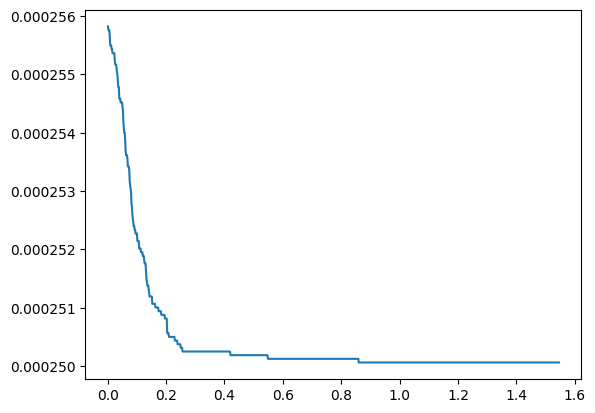

In [13]:
j = 1000
dist_subsequent = np.abs( int_contour[:,:-1] - int_contour[:,1:] ).sum(axis=0)
test = np.vectorize( lambda threshold : (dist_subsequent < threshold).sum() )
thresholds = np.linspace(dist_subsequent.min()*(1.0001),dist_subsequent.max()*(1.8),j)

plt.plot(thresholds, 1 / test(thresholds))

Relying on the graph above we now chose a threshold

In [14]:
threshold = 0.5

Thanks to homogeneity and the relation between contours and region, we can then plot the tail quantile region of order $q$.

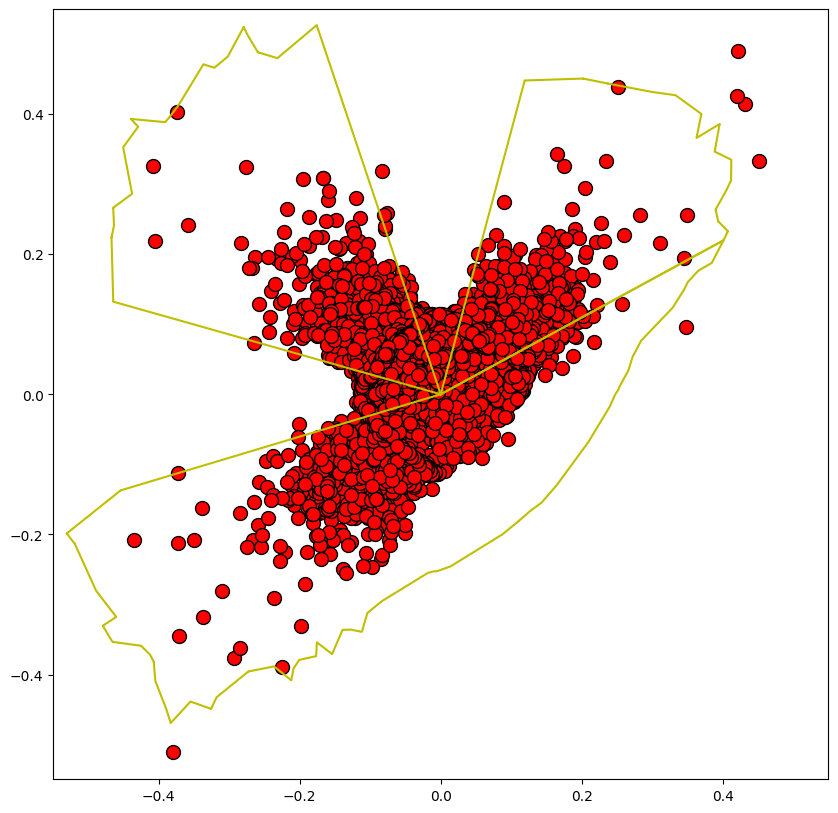

In [15]:
plotr(Y_real, 
        int_contour, 
        [], 
        b, 
        beta, 
        alpha, 
        threshold = threshold, 
        color = ["r", "y"],
        norm_max = norm_max,
        rescale = True)

Estimation of the non-extremal center-outward regions of order as large as possible. Since the regions are nested but not the contours, and as we know that the regions will include rays-it is clear knowing the distribution puts mass on the origin-, we estimate the contours for some orders and keep all the associated regions.

$$
\mathbb{C}(p_t)
\approx
\bigcup_{t\le p_t} \bigcup_{y\in\mathcal{C}(t)}[0,y]
\approx
\bigcup_{t\le p_t} \left\{[0,\nabla\hat{\psi}(x)] \::\: \mathbb{P}(X\le|x|) = t\right\}
$$

In [16]:
p_ts = np.linspace(max(p_t,0.2),0.5,3)
hallin_contours = []

for p in p_ts:
    b_bis = tmpb[int(n*(1-p))]

    Theta = np.linspace(0,2*np.pi,i)
    tmp = np.vstack((np.cos(Theta), np.sin(Theta).T)).T
    rad = b_bis
    ref_contour_bis = rad * tmp.T

    hallin_contour = np.zeros((2,i))
    for k in range(0,i):
        hallin_contour[:,k] = T(ref_contour_bis[:,k])
    
    hallin_contours.append(hallin_contour)


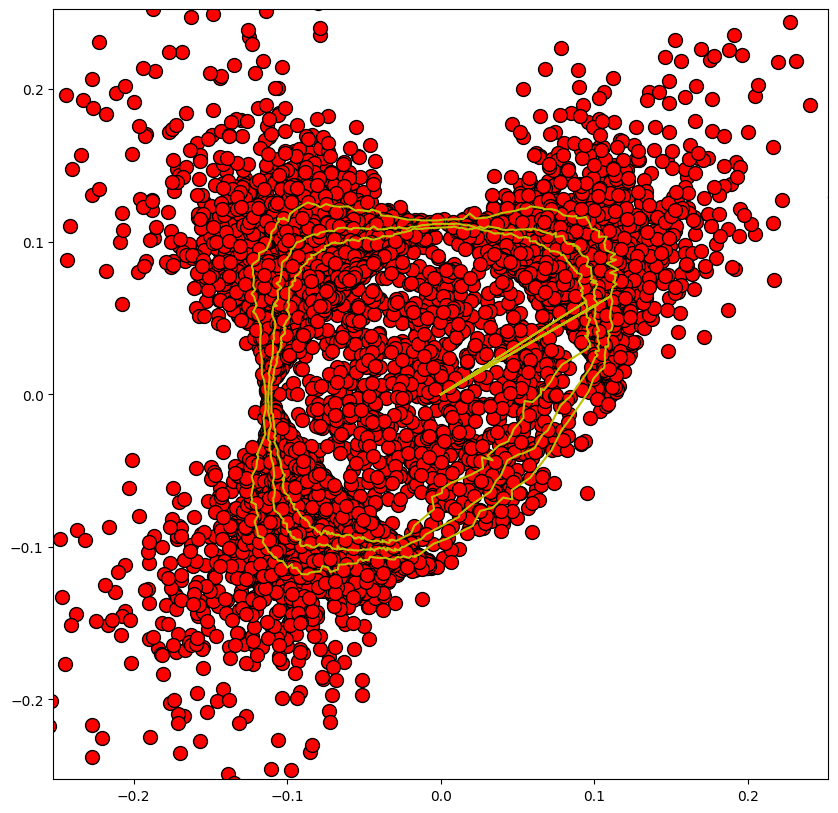

In [17]:
plotr(Y_real, 
        [], 
        hallin_contours, 
        b, 
        beta, 
        alpha, 
        threshold = threshold, 
        color = ["r", "y"],
        norm_max = norm_max,
        rescale = True)

## Monte Carlo estimation of the mass of the estimated center-outward quantile region

For some large $t^* = 1 / p_{t^*}$ we build an approximation of the center-outward quantile region of order $q$ relying on the approximation proposed in the working document
$$
\mathbb{C}(q)
\approx \mathbb{C}(1-1/t^*) \cup b(t*) \mathbb{C}^\tau(\beta)
$$
where $\beta=(q-1+p_{t^*}) / p_{t^*}$ for $p_{t^*}$ the share of data deemed extreme that has been defined in the parameters at the beginning of the current notebook and $b(t^*) = F^{\leftarrow}(1-p_{t^*}) $ is estimated the simpliest way.

On the graph below our estimated region is the union of the yellow polygons.

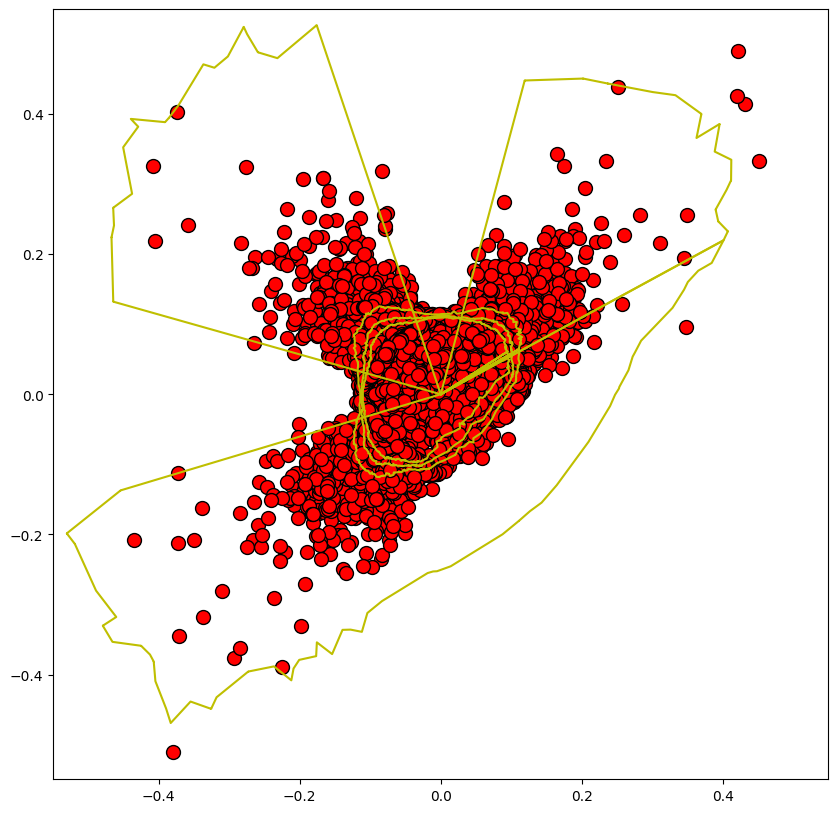

In [18]:
plotr(Y_real, 
        int_contour, 
        hallin_contours, 
        b, 
        beta, 
        alpha, 
        threshold = threshold,
        color = ["r", "y"],
        norm_max = norm_max,
        rescale = True)

We can now use a Monte-Carlo approach to estimate the probability of a point being inside the estimated region. To do so we use Shapely to define our regions as Polygon objects and easily test wether new generated points lie in it.

In [19]:
extremal_polygons = []

final_evt_contour = b * (1-beta)**(-1/alpha) * int_contour
splits = np.argwhere(dist_subsequent > threshold)
last = 0
for index in range(splits.shape[0] + 1):
    if index == splits.shape[0] :
        split = final_evt_contour.shape[1] + 1
    else:
        split = splits[index,0]

    if split-last > 1:
        tmp = np.zeros(((final_evt_contour[:,last:(split)]).shape[1]+1,2))
        tmp[:-1,:] = (final_evt_contour[:,last:(split)]).T
        extremal_polygons.append( Polygon(tmp) )

    last = split + 1

hallin_regions = []
for cont in hallin_contours:
    tmp = np.zeros((cont.shape[1]+1,2))
    tmp[:-1,:] = cont.T
    hallin_regions.append( Polygon(tmp) )

quantile_region = hallin_regions + extremal_polygons


In [20]:
# Use SLLN to estimate the probability of being in the estimated quantile region
N = 1000000
new_points = generator(N).T
counter_in = 0
indices_in = []
indices_out = []
for i in range(N):
    test = False
    for region in quantile_region:
        if region.contains(Point(new_points[i,:])):
            counter_in += 1
            indices_in.append(i)
            test = True
            break
    if not test:
        indices_out.append(i)

In [21]:
print(f'Probability of the estimated region: {counter_in/N} \nProbability of the desired region: {q}')

Probability of the estimated region: 0.994633 
Probability of the desired region: 0.999


The probability of the estimated region is close to the desired probability $q$. Moreover, as one can see on the graph below, the estimated region is almost "full" of points, meaning that it does not include some areas of the space with no mass in this example, whence there is no over-estimation of the risks in concrete application and that this method could be successfully used in anomaly detection. 

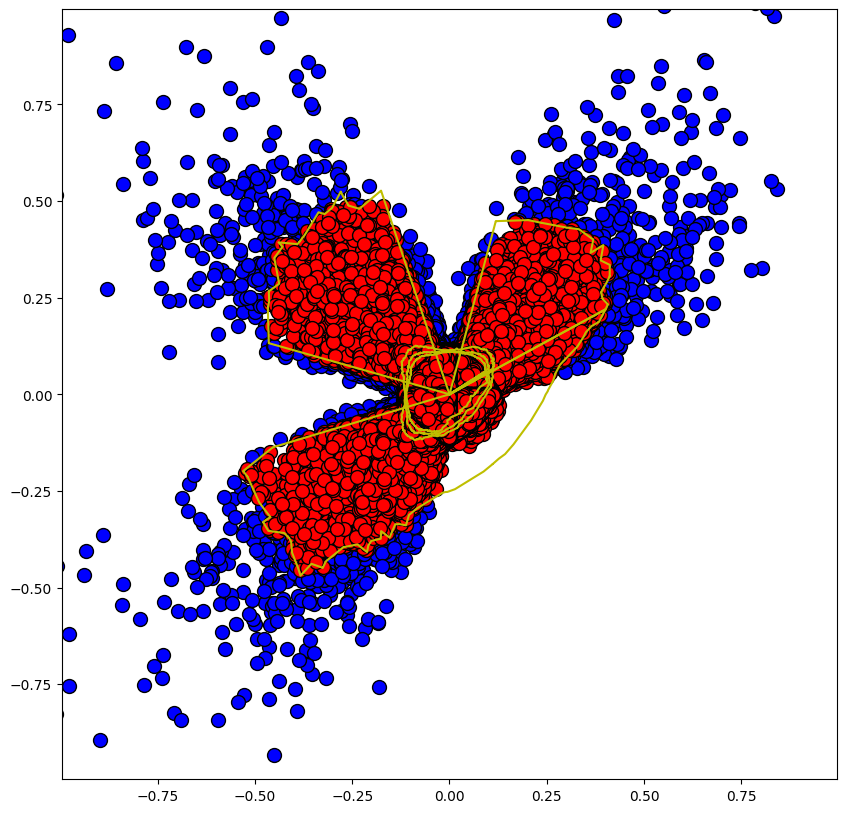

In [22]:
plotr([new_points[indices_out,:].T,
       new_points[indices_in,: ].T], 
        int_contour, 
        hallin_contours, 
        b, 
        beta, 
        alpha, 
        threshold = threshold,
        color = ["b", "r", "y"],
        norm_max = norm_max,
        rescale = True)